# 모멘텀 시그널

- 옵션이 ITM으로 끝나는지 OTM으로 끝나는지 ATM으로 끝나는지 등을 보기 위함

In [27]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from pathlib import Path

from tqdm import tqdm

In [28]:
CWD_PATH = Path.cwd()
DATA_PATH = CWD_PATH / 'data'
OUTPUT_PATH = CWD_PATH / 'output'

In [29]:
data_df = pd.read_parquet(OUTPUT_PATH / 'option_data_targets_20220101-20241204.parquet')

## underlying만 남기기 

In [30]:
ticker = '005930'

In [31]:
data_df = data_df[data_df['ticker'] == ticker]

In [32]:
udly_cols = [
    'trade_date',
    'udly_open',
    'udly_high',
    'udly_low',
    'udly_close',
    'udly_volume',
    'udly_return',   
]

In [33]:
data_df = data_df[udly_cols].drop_duplicates().sort_values('trade_date').reset_index(drop=True)

In [34]:
data_df.set_index('trade_date', inplace=True)

In [35]:
fig = go.Figure(data=[go.Candlestick(
    x=data_df.index,
    open=data_df['udly_open'],
    high=data_df['udly_high'],
    low=data_df['udly_low'],
    close=data_df['udly_close'],
)])

In [36]:
fig.update_layout(
    title=f'{ticker} Daily Candlestick',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False,
)

fig.show()

## 시그널

- 캔들 

In [38]:
# 1. Short term moving average deviation

import numpy as np
import pandas as pd

def sma_momentum_signal(data_df, window=5):
    # Calculate 5-day SMA of close
    sma = data_df['udly_close'].rolling(window=window).mean()
    # Compute ratio: (close - SMA)/SMA
    ratio = (data_df['udly_close'] - sma) / sma
    # Use tanh to scale into (-1,1)
    signal = np.tanh(ratio)
    return signal


In [39]:
# 2. recent returns momentum signal

def recent_returns_momentum_signal(data_df, window=10):
    # Rolling sum of returns
    rolling_sum = data_df['udly_return'].rolling(window=window).sum()
    # Standard deviation of recent returns for scaling
    rolling_std = data_df['udly_return'].rolling(window=window).std()
    
    # Avoid division by zero
    scaled = rolling_sum / (rolling_std + 1e-9)
    # Tanh for (-1,1)
    signal = np.tanh(scaled)
    return signal


In [40]:
# 3. RSI based momentum signal 

def rsi_momentum_signal(data_df, period=14):
    # Calculate RSI
    # RSI = 100 - [100/(1 + avg_gain/avg_loss)]
    diff = data_df['udly_close'].diff()
    gain = diff.clip(lower=0)
    loss = -diff.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    rsi = 100 - (100 / (1 + rs))
    
    # Scale RSI: (RSI - 50)/50 => [-1, 1]
    signal = (rsi - 50) / 50
    return signal


In [41]:
# 4. Price channel breakout positioning

def channel_position_signal(data_df, window=20):
    # Rolling highest high and lowest low
    highest = data_df['udly_high'].rolling(window=window).max()
    lowest = data_df['udly_low'].rolling(window=window).min()
    # Position of close within the channel
    position = (data_df['udly_close'] - lowest) / (highest - lowest + 1e-9)
    # Scale to (-1, 1)
    signal = 2 * position - 1
    return signal


In [42]:
# 5. Intraday momentum signal 

def intraday_momentum_signal(data_df):
    day_range = (data_df['udly_high'] - data_df['udly_low']) + 1e-9
    position = (data_df['udly_close'] - data_df['udly_low']) / day_range
    signal = 2 * position - 1
    return signal


In [43]:
# 6. gap momentum strategy

import numpy as np

def gap_momentum_signal(data_df):
    prev_close = data_df['udly_close'].shift(1)
    gap = (data_df['udly_open'] - prev_close) / (prev_close + 1e-9)
    signal = np.tanh(gap)
    return signal


In [44]:
# 7. volume breakout

def volatility_breakout_signal(data_df, window=20):
    # Normalized daily range
    daily_range_norm = (data_df['udly_high'] - data_df['udly_low']) / (data_df['udly_close'] + 1e-9)
    
    # Rolling average of normalized daily ranges
    rolling_avg_range = daily_range_norm.rolling(window=window).mean()
    
    # Ratio of today's range to recent average (subtract 1 so that 1 means no change)
    ratio = (daily_range_norm / (rolling_avg_range + 1e-9)) - 1
    
    # Position of close within today's range (2P_t - 1 maps [0,1] to [-1,1])
    pos = (data_df['udly_close'] - data_df['udly_low']) / ((data_df['udly_high'] - data_df['udly_low']) + 1e-9)
    pos_scaled = 2 * pos - 1
    
    # Combine ratio and position and apply tanh to ratio (pos is already [-1,1])
    signal = np.tanh(ratio) * pos_scaled
    return signal


In [45]:
# 8. Volume Spike Confirmation Signal

import numpy as np
import pandas as pd

def volume_spike_confirmation_signal(data_df, window=20):
    avg_vol = data_df['udly_volume'].rolling(window=window).mean()
    vol_ratio = (data_df['udly_volume'] / (avg_vol + 1e-9))
    
    price_dir = (data_df['udly_close'] - data_df['udly_open']) / (data_df['udly_open'] + 1e-9)
    combined = vol_ratio * price_dir
    
    signal = np.tanh(combined)
    return signal


In [47]:
# 9. On-Balance Volume (OBV) Momentum Signal

def obv_momentum_signal(data_df, window=20):
    close = data_df['udly_close']
    volume = data_df['udly_volume']
    
    # Compute OBV
    direction = np.sign(close.diff().fillna(0))
    # direction: +1 if up, -1 if down, 0 if flat
    obv = (direction * volume).cumsum()
    
    # Compute a rolling standard deviation and difference
    obv_diff = (obv - obv.shift(window)) / (obv.rolling(window=window).std() + 1e-9)
    
    signal = np.tanh(obv_diff)
    return signal


In [ ]:
# 10. Volume-Adjusted Volatility Breakout Signal

def volume_adjusted_breakout_signal(data_df, window=20):
    close = data_df['udly_close']
    high = data_df['udly_high']
    low = data_df['udly_low']
    volume = data_df['udly_volume']
    
    # Normalized daily range
    daily_range_norm = (high - low) / (close + 1e-9)
    
    # Rolling averages
    avg_range = daily_range_norm.rolling(window=window).mean()
    avg_vol = volume.rolling(window=window).mean()
    
    # Ratios
    range_ratio = (daily_range_norm / (avg_range + 1e-9)) - 1
    vol_ratio = (volume / (avg_vol + 1e-9)) - 1
    
    # Combine and factor in the candle's close position
    combined = range_ratio * vol_ratio
    pos = (close - low) / ((high - low) + 1e-9)
    pos_scaled = 2 * pos - 1
    
    signal = np.tanh(combined) * pos_scaled
    return signal


In [50]:
mom1 = sma_momentum_signal(data_df)
mom2 = recent_returns_momentum_signal(data_df)
mom3 = rsi_momentum_signal(data_df)
mom4 = channel_position_signal(data_df)
mom5 = intraday_momentum_signal(data_df)
mom6 = gap_momentum_signal(data_df)
mom7 = volatility_breakout_signal(data_df)
mom8 = volume_spike_confirmation_signal(data_df)
mom9 = obv_momentum_signal(data_df)
mom10 = volume_adjusted_breakout_signal(data_df)


In [51]:
data_df['mom1'] = mom1
data_df['mom2'] = mom2
data_df['mom3'] = mom3
data_df['mom4'] = mom4
data_df['mom5'] = mom5
data_df['mom6'] = mom6
data_df['mom7'] = mom7
data_df['mom8'] = mom8
data_df['mom9'] = mom9
data_df['mom10'] = mom10

In [60]:
performance = data_df[
    [
        'mom1',
        'mom2',
        'mom3',
        'mom4',
        'mom5',
        'mom6',
        'mom7',
        'mom8',
        'mom9',
        'mom10',
    ]
].copy()

performance = performance.shift(1)
performance = performance.mul(data_df['udly_return'], axis=0).cumsum()

<Axes: title={'center': 'Momentum Strategy Performance'}, xlabel='trade_date'>

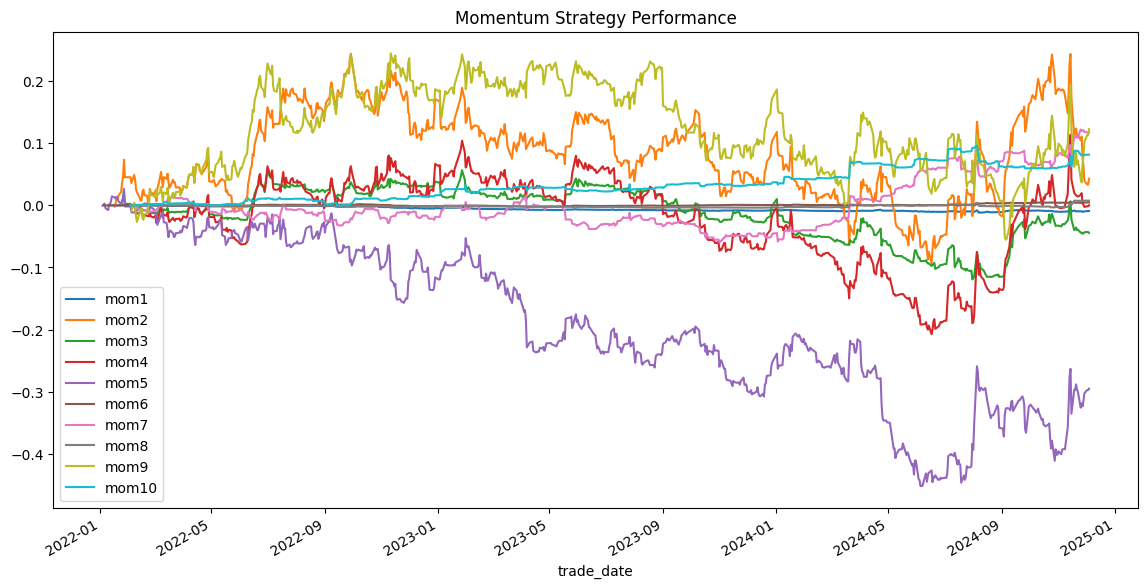

In [61]:
performance.plot(title='Momentum Strategy Performance', figsize=(14, 7))

In [62]:
performance.iloc[-1].sort_values(ascending=False)

mom9     0.122383
mom7     0.116991
mom10    0.081453
mom2     0.042622
mom8     0.007528
mom6     0.004561
mom4     0.000087
mom1    -0.009154
mom3    -0.044538
mom5    -0.295215
Name: 2024-12-04 00:00:00, dtype: float64

In [63]:
mom_to_name = {
    'mom1': 'SMA Momentum',
    'mom2': 'Recent Returns Momentum',
    'mom3': 'RSI Momentum',
    'mom4': 'Channel Position',
    'mom5': 'Intraday Momentum',
    'mom6': 'Gap Momentum',
    'mom7': 'Volatility Breakout',
    'mom8': 'Volume Spike Confirmation',
    'mom9': 'OBV Momentum',
    'mom10': 'Volume-Adjusted Breakout',
}

In [64]:
mom9.to_pickle(OUTPUT_PATH / 'mom9.pkl')
mom7.to_pickle(OUTPUT_PATH / 'mom7.pkl')
mom10.to_pickle(OUTPUT_PATH / 'mom10.pkl')

In [66]:
data_df.to_pickle(OUTPUT_PATH / 'samsung_df.pkl')